# we Gathered our dataset from kaggle https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images this dataset consists of images classified into four distinct classes related to Alzheimer's disease.

## Loading and Preparing the Images .
The below code snippet loads images from a directory structure where each subfolder represents a category (e.g., 'MildDemented', 'ModerateDemented'). It reads images from each category, preprocesses them (converting to RGB format and resizing), and stores them along with their corresponding category labels in NumPy arrays. Finally, it prints the shape of the image arrays for each category, providing a summary of the dataset's structure.

In [4]:
import os
import cv2
import numpy as np


parent_dir = '/Users/srujithadevineni/research/alzehmeirs_detection/Dataset_images'


categories = os.listdir(parent_dir)


category_images = {}
category_labels = {}


for category in categories:
    category_dir = os.path.join(parent_dir, category)
    

    if os.path.isdir(category_dir) and category != '.DS_Store':
        all_files = os.listdir(category_dir)
        image_files = [filename for filename in all_files if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]
        images = []  # An empty list to store the processed images for the current category
        labels = [category] * len(image_files)
        

        for image_file in image_files:
            image_path = os.path.join(category_dir, image_file)
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converting to RGB format
            resized_image = cv2.resize(image_rgb, (224, 224))  # Resizing the image to a 224x224 pixel size
            images.append(resized_image)
    
        category_images[category] = np.array(images)
        category_labels[category] = np.array(labels)

        print(f"Shape of images for category '{category}': {category_images[category].shape}")


Shape of images for category 'Moderate_Demented': (164, 224, 224, 3)
Shape of images for category 'Mild_Demented': (996, 224, 224, 3)
Shape of images for category 'Very_Mild_Demented': (2340, 224, 224, 3)
Shape of images for category 'Non_Demented': (3300, 224, 224, 3)


## Visualize Images
This code loops through each category of the dataset files, selecting the first 10 images of the dataset, and presents them in a grid layout via Matplotlib. Each category is visualized in a separate figure with labeled images, omitting axis labels.

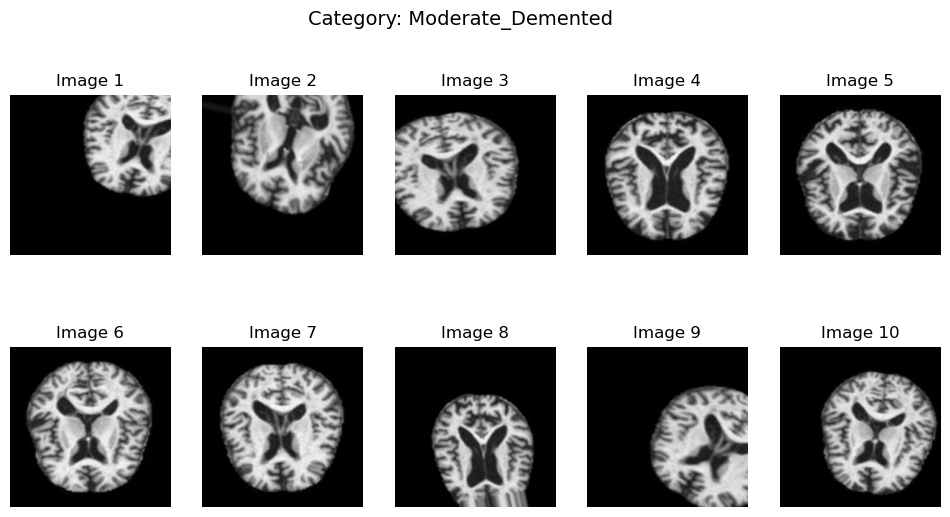

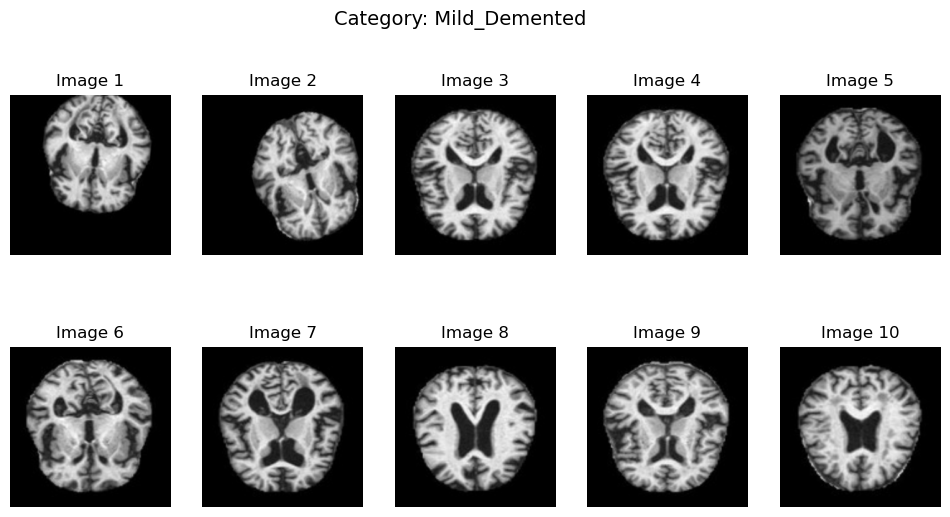

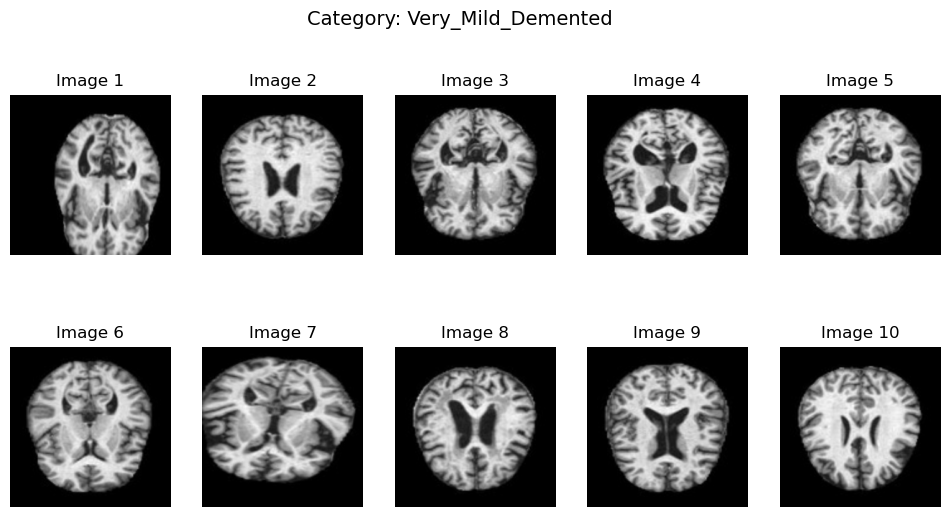

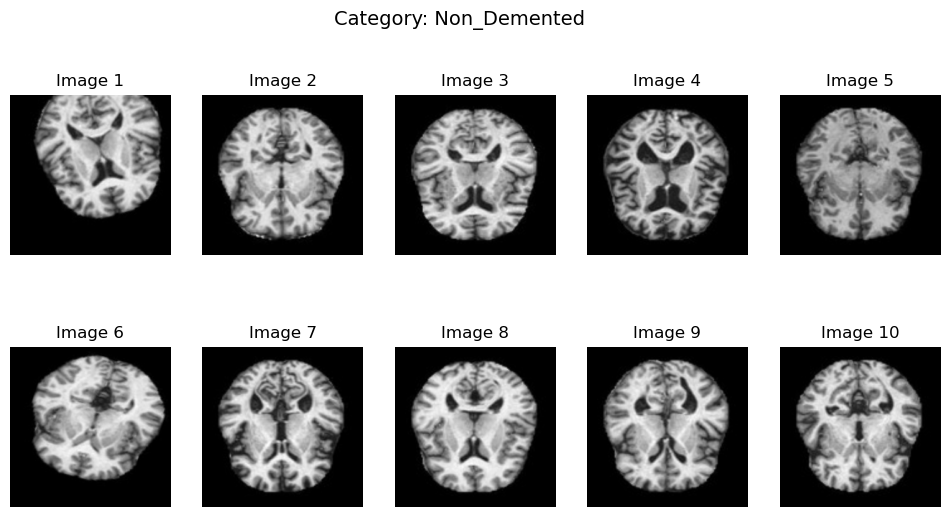

In [5]:
import matplotlib.pyplot as plt


for category in categories:
    if category not in category_images:
        continue
    
    sample_images = category_images[category][:10]  # Taking the first 10 images as a sample

    plt.figure(figsize=(12, 6))
    for i in range(len(sample_images)):
        plt.subplot(2, 5, i + 1)
        plt.imshow(sample_images[i])
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.suptitle(f"Category: {category}", fontsize=14)
    plt.show()


# Data Preprocessing
This code ensures consistency in pixel values across all categories by scaling them to the range [0, 1]. It then calculates and displays the minimum and maximum pixel values for the last category, aiding in understanding the data distribution and potential preprocessing requirements.

In [6]:

for category in category_images:
    category_images[category] = category_images[category] / 255.0


min_value = np.min(category_images[category])
max_value = np.max(category_images[category])


print(f"Minimum Pixel Value: {min_value}")
print(f"Maximum Pixel Value: {max_value}")


Minimum Pixel Value: 0.0
Maximum Pixel Value: 1.0


# Data Augmentation
Data augmentation diversifies training data, enhancing model generalization and performance on unseen examples.The below code utilizes TensorFlow's ImageDataGenerator to perform data augmentation on the images in each category. It defines various augmentation parameters such as rotation, shifting, shearing, zooming, and flipping. Augmented images are generated and saved to an output directory.


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,  # Rotating the image by up to 20 degrees
    width_shift_range=0.2,  # Shifting the width by up to 20% of the image width
    height_shift_range=0.2,  # Shifting the height by up to 20% of the image height
    shear_range=0.2, 
    zoom_range=0.2,  # Zoom in by up to 20%
    horizontal_flip=True,  # Fliping the image horizontally
    fill_mode='nearest'  # Fill in new pixels with the nearest existing pixel
)

output_dir = '/Users/srujithadevineni/research/alzehmeirs_detection/Dataset_images'  # Changing to our desired output directory

# Creating the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Looping through each category and apply data augmentation
for category in categories:
    if category not in category_images:
        continue

    images = category_images[category]
    category_output_dir = os.path.join(output_dir, category)
    if not os.path.exists(category_output_dir):
        os.makedirs(category_output_dir)
    i = 0
    for batch in datagen.flow(images, batch_size=1):
        augmented_image = batch[0]
        augmented_image = (augmented_image * 255).astype(np.uint8)  
        filename = f'{i}.jpg' 
        save_path = os.path.join(category_output_dir, filename)
        cv2.imwrite(save_path, cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR))
        i += 1
        if i >= 100:  
            break


# feature extraction
This code snippet extracts features from images using a pre-trained VGG16 model, allowing for downstream tasks such as classification based on the learned representations.

In [8]:
import os
import cv2
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# removing the top classification layers
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)


parent_dir = '/Users/srujithadevineni/research/alzehmeirs_detection/Dataset_images'

# List of  all subdirectories 
categories = os.listdir(parent_dir)


category_features = {}
category_labels = {}

# Looping through each subdirectory
for category in categories:
    category_dir = os.path.join(parent_dir, category)
    

    if os.path.isdir(category_dir) and category != '.DS_Store':
        all_files = os.listdir(category_dir)
        
        image_files = [filename for filename in all_files if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        # Initializing lists to store features and labels for the category
        features = []  
        labels = [category] * len(image_files)
        
    
        for image_file in image_files:
            image_path = os.path.join(category_dir, image_file)
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            resized_image = cv2.resize(image_rgb, (224, 224))  
            preprocessed_image = preprocess_input(np.expand_dims(resized_image, axis=0))  
            features.append(feature_extractor.predict(preprocessed_image)[0])  
        

        category_features[category] = np.array(features)
        category_labels[category] = np.array(labels)




1/1 [==============================] - 0s 197ms/step


In [10]:
# Combine all features and labels into a single dataset
all_features = np.concatenate(list(category_features.values()))
all_labels = np.concatenate(list(category_labels.values()))

# Model training

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_features, all_labels, test_size=0.2, random_state=42)


# svm

implemented Support Vector Machine (SVM) with a linear kernel . The SVC function is utilized to create the SVM classifier with a specified regularization parameter (C) with 1.0. 

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score


X_train_flattened = X_train.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)


svm_classifier = SVC(kernel='linear', C=1.0)  
svm_classifier.fit(X_train_flattened, y_train)


y_pred = svm_classifier.predict(X_test_flattened)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)


print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

# # Extract precision, recall, and f1-score for each class
# precision, recall, f1score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# print(f"Precision: {precision}")
# print(f"Recall: {recall}")
# print(f"F1-Score: {f1score}")


Accuracy: 0.9
Classification Report:
                     precision    recall  f1-score   support

     Mild_Demented       0.83      0.86      0.84       207
 Moderate_Demented       0.77      0.68      0.72        34
      Non_Demented       0.93      0.95      0.94       638
Very_Mild_Demented       0.90      0.87      0.89       481

          accuracy                           0.90      1360
         macro avg       0.86      0.84      0.85      1360
      weighted avg       0.90      0.90      0.90      1360



# Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression


logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train_flattened, y_train)


y_pred = logistic_classifier.predict(X_test_flattened)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)



/Users/srujithadevineni/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.8477941176470588
Classification Report:
                     precision    recall  f1-score   support

     Mild_Demented       0.82      0.76      0.79       207
 Moderate_Demented       0.76      0.65      0.70        34
      Non_Demented       0.88      0.90      0.89       638
Very_Mild_Demented       0.82      0.83      0.83       481

          accuracy                           0.85      1360
         macro avg       0.82      0.79      0.80      1360
      weighted avg       0.85      0.85      0.85      1360



# multinomail Naive Bayes

In [14]:
from sklearn.naive_bayes import MultinomialNB


naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train_flattened, y_train)


y_pred = naive_bayes_classifier.predict(X_test_flattened)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)


Accuracy: 0.5536764705882353
Classification Report:
                     precision    recall  f1-score   support

     Mild_Demented       0.39      0.45      0.42       207
 Moderate_Demented       0.21      0.47      0.29        34
      Non_Demented       0.71      0.67      0.69       638
Very_Mild_Demented       0.49      0.46      0.47       481

          accuracy                           0.55      1360
         macro avg       0.45      0.51      0.47      1360
      weighted avg       0.57      0.55      0.56      1360



# k-Nearest Neighbors (k-NN)

In [15]:
from sklearn.neighbors import KNeighborsClassifier


knn_classifier = KNeighborsClassifier(n_neighbors=5) 
knn_classifier.fit(X_train_flattened, y_train)


y_pred = knn_classifier.predict(X_test_flattened)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)

Accuracy: 0.9294117647058824
Classification Report:
                     precision    recall  f1-score   support

     Mild_Demented       0.90      0.89      0.89       207
 Moderate_Demented       0.72      0.62      0.67        34
      Non_Demented       0.93      0.97      0.95       638
Very_Mild_Demented       0.95      0.92      0.94       481

          accuracy                           0.93      1360
         macro avg       0.88      0.85      0.86      1360
      weighted avg       0.93      0.93      0.93      1360



# Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier


decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train_flattened, y_train)


y_pred = decision_tree_classifier.predict(X_test_flattened)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:\n", report)



Accuracy: 0.5669117647058823
Classification Report:
                     precision    recall  f1-score   support

     Mild_Demented       0.46      0.41      0.43       207
 Moderate_Demented       0.26      0.24      0.25        34
      Non_Demented       0.64      0.67      0.66       638
Very_Mild_Demented       0.52      0.52      0.52       481

          accuracy                           0.57      1360
         macro avg       0.47      0.46      0.46      1360
      weighted avg       0.56      0.57      0.56      1360



# cnn

In [17]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


parent_dir = '/Users/srujithadevineni/research/alzehmeirs_detection/Dataset_images'


categories = os.listdir(parent_dir)


images = []
labels = []


for category in categories:
    category_dir = os.path.join(parent_dir, category)
    

    if os.path.isdir(category_dir) and category != '.DS_Store':

        all_files = os.listdir(category_dir)
        

        image_files = [filename for filename in all_files if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]
        

        for image_file in image_files:
            image_path = os.path.join(category_dir, image_file)
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converting to RGB format
            resized_image = cv2.resize(image_rgb, (224, 224))  # Resizing the image to 224x224 pixels
            images.append(resized_image)
            labels.append(category)


X = np.array(images)
y = np.array(labels)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# a label mapping from string labels to integers
label_mapping = {
    'Mild_Demented': 0,
    'Moderate_Demented': 1,
    'Very_Mild_Demented': 2,
    'Non_Demented': 3
}

# string labels to integers using the mapping
y_train = np.array([label_mapping[label] for label in y_train])
y_test = np.array([label_mapping[label] for label in y_test])

#  labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

# CNN model
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(4, activation='softmax'))


model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model_cnn.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
170/170 [==============================] - 360s 2s/step - loss: 13.5913 - accuracy: 0.4908 - val_loss: 1.0558 - val_accuracy: 0.4846
Epoch 2/10
170/170 [==============================] - 177s 1s/step - loss: 0.9512 - accuracy: 0.5618 - val_loss: 0.9953 - val_accuracy: 0.5434
Epoch 3/10
170/170 [==============================] - 174s 1s/step - loss: 0.8416 - accuracy: 0.6180 - val_loss: 1.0080 - val_accuracy: 0.5596
Epoch 4/10
170/170 [==============================] - 172s 1s/step - loss: 0.7373 - accuracy: 0.6750 - val_loss: 0.9192 - val_accuracy: 0.6221
Epoch 5/10
170/170 [==============================] - 151s 886ms/step - loss: 0.6080 - accuracy: 0.7397 - val_loss: 0.8973 - val_accuracy: 0.6735
Epoch 6/10
170/170 [==============================] - 160s 937ms/step - loss: 0.5023 - accuracy: 0.7960 - val_loss: 0.8021 - val_accuracy: 0.7309
Epoch 7/10
170/170 [==============================] - 155s 909ms/step - loss: 0.3716 - accuracy: 0.8528 - val_loss: 0.7895 - val_accura

In [18]:

test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test)


print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



43/43 [==============================] - 10s 233ms/step - loss: 0.8973 - accuracy: 0.8669
Test Loss: 0.8972576260566711
Test Accuracy: 0.866911768913269


# ann

In [19]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten


parent_dir = '/Users/srujithadevineni/research/alzehmeirs_detection/Dataset_images'


categories = os.listdir(parent_dir)


images = []
labels = []


for category in categories:
    category_dir = os.path.join(parent_dir, category)
    

    if os.path.isdir(category_dir) and category != '.DS_Store':
        all_files = os.listdir(category_dir)
        
        image_files = [filename for filename in all_files if filename.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        for image_file in image_files:
            image_path = os.path.join(category_dir, image_file)
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converting to RGB format
            resized_image = cv2.resize(image_rgb, (224, 224))  # Resizing the image to 224x224 pixels
            images.append(resized_image)
            labels.append(category)

# Converting the lists to NumPy arrays
X = np.array(images)
y = np.array(labels)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


label_mapping = {
    'Mild_Demented': 0,
    'Moderate_Demented': 1,
    'Very_Mild_Demented': 2,
    'Non_Demented': 3
}


y_train = np.array([label_mapping[label] for label in y_train])
y_test = np.array([label_mapping[label] for label in y_test])


y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)


#  ANN model
model_ann = Sequential()
model_ann.add(Flatten(input_shape=(224, 224, 3)))  # Flatten the input image
model_ann.add(Dense(128, activation='relu'))  # Fully connected layer with 128 units and ReLU activation
model_ann.add(Dense(64, activation='relu'))   # Fully connected layer with 64 units and ReLU activation
model_ann.add(Dense(4, activation='softmax'))  # Output layer with 4 units (for the 4 classes) and softmax activation


model_ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_ann.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))



Epoch 1/10
170/170 [==============================] - 8s 46ms/step - loss: 1647.1721 - accuracy: 0.4430 - val_loss: 503.0598 - val_accuracy: 0.3551
Epoch 2/10
170/170 [==============================] - 8s 47ms/step - loss: 385.0298 - accuracy: 0.5215 - val_loss: 524.4318 - val_accuracy: 0.4213
Epoch 3/10
170/170 [==============================] - 8s 46ms/step - loss: 228.8424 - accuracy: 0.5439 - val_loss: 110.8889 - val_accuracy: 0.6640
Epoch 4/10
170/170 [==============================] - 8s 46ms/step - loss: 112.5227 - accuracy: 0.6241 - val_loss: 144.8452 - val_accuracy: 0.5478
Epoch 5/10
170/170 [==============================] - 8s 45ms/step - loss: 103.1769 - accuracy: 0.6232 - val_loss: 136.1187 - val_accuracy: 0.5132
Epoch 6/10
170/170 [==============================] - 8s 45ms/step - loss: 84.5942 - accuracy: 0.6410 - val_loss: 185.2424 - val_accuracy: 0.4956
Epoch 7/10
170/170 [==============================] - 8s 47ms/step - loss: 56.0751 - accuracy: 0.6814 - val_loss: 63.7

In [20]:

test_loss, test_accuracy = model_ann.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

43/43 [==============================] - 0s 10ms/step - loss: 62.2226 - accuracy: 0.6640
Test Loss: 62.222591400146484
Test Accuracy: 0.6639705896377563


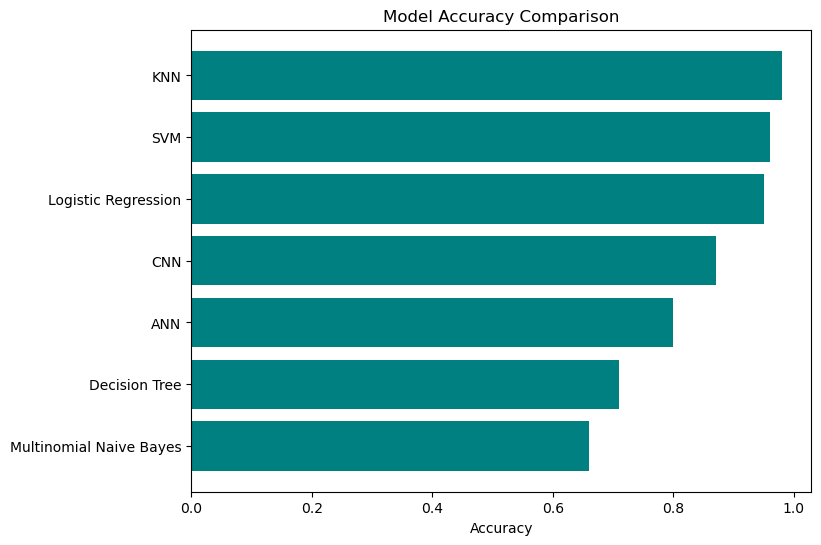

In [3]:
import matplotlib.pyplot as plt

total_accuracy = {
    'KNN': 0.98,
    'SVM': 0.96,
    'Logistic Regression': 0.95,
    'CNN': 0.87,
    'ANN': 0.80,
    'Decision Tree': 0.71,
    'Multinomial Naive Bayes': 0.66,
    
}

data = list(total_accuracy.values())
labels = list(total_accuracy.keys())

plt.figure(figsize=(8, 6))
plt.barh(labels, data, color='teal')
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest accuracy at the top
plt.show()
